# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix,roc_auc_score,log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb 
seed = 4353

# Load data set

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Explore data set

In [3]:
print('Number of rows and columns in data set',train.shape)
train.head()

Number of rows and columns in data set (19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
print('Number of rows and columns in data set',test.shape)
test.head()

Number of rows and columns in data set (8392, 2)


,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


# Authors Target variable distribution

In [5]:
train['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

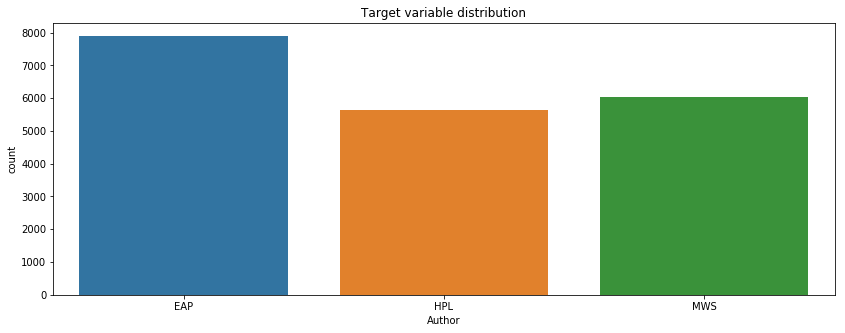

In [6]:
plt.figure(figsize=(14,5))
sns.countplot(train['author'],)
plt.xlabel('Author')
plt.title('Target variable distribution')
plt.show()

# Text cleaning

## Remove unwanted punctuation mark

In [7]:
print('Original text:\n',train['text'][0])
review = re.sub('[^A-Za-z0-9]'," ",train['text'][0]) 
print('\nAfter removal of punctuation:\n',review)

Original text:
 This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.

After removal of punctuation:
 This process  however  afforded me no means of ascertaining the dimensions of my dungeon  as I might make its circuit  and return to the point whence I set out  without being aware of the fact  so perfectly uniform seemed the wall 


# Split sentence into word

In [8]:
review = word_tokenize(train['text'][0]) 
print('Word Tokenize:\n',review)

review = [word for word in str(train['text'][0]).lower().split() if  word not in set(stopwords.words('english'))]
print('\nRemoval of Stopwords:\n',review)

review = [word for word in str(train['text'][0]).lower().split() if  word in set(stopwords.words('english'))]
print('\nStopwords in the sentence:\n',review)

ps = PorterStemmer()
review = [ps.stem(word) for word in str(train['text'][0]).lower().split()]
print('\nStemming of word:\n',review)

Word Tokenize:
 ['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']

Removal of Stopwords:
 ['process,', 'however,', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon;', 'might', 'make', 'circuit,', 'return', 'point', 'whence', 'set', 'out,', 'without', 'aware', 'fact;', 'perfectly', 'uniform', 'seemed', 'wall.']

Stopwords in the sentence:
 ['this', 'me', 'no', 'of', 'the', 'of', 'my', 'as', 'i', 'its', 'and', 'to', 'the', 'i', 'being', 'of', 'the', 'so', 'the']

Stemming of word:
 ['thi', 'process,', 'however,', 'afford', 'me', 'no', 'mean', 'of', 'ascertain', 'the', 'dimens', 'of', 'my', 'dungeon;', 'as', 'i', 'might', 'make', 'it', 'circuit,', 'a

# Function for text cleaning

In [9]:
def clean_text(df):
    ps = PorterStemmer()
    corpus = []
    for i in range(0, df.shape[0]):        
        review = re.sub('[^A-Za-z0-9]'," ",df['text'][i])
        review = word_tokenize(review)        
        review = [word for word in review if word.lower() not in set(stopwords.words('english'))]
        review = [ps.stem(word) for word in review]
        review = ' '.join(review)
        corpus.append(review)
    
    return corpus

In [10]:
corp_train = clean_text(train)
corp_test = clean_text(test)
train['clean_text'] = corp_train
test['clean_text'] = corp_test
del corp_train,corp_test

# Determine length of text

In [11]:
def text_len(df):
    #i = ['text']
    df['num_words'] = df['text'].apply(lambda x: len(str(x).split()))
    df['num_uniq_words'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['num_chars'] = df['text'].apply(lambda x: len(str(x)))
    df['num_stopwords'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() 
                                                          if w in set(stopwords.words('english'))]))
    df['num_punctuations'] = df['text'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))
    df['num_words_upper'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df['num_words_title'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['mean_word_len'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

text_len(train)
text_len(test)

# Data analysis

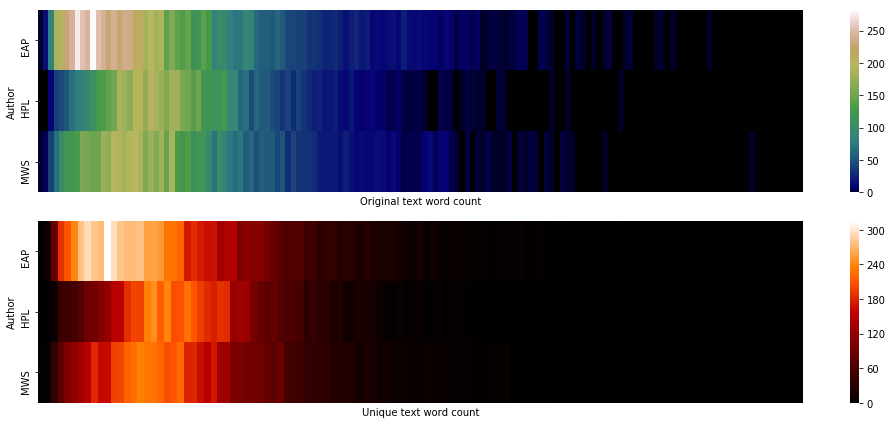

In [12]:
plt.figure(figsize=(14,6))
plt.subplot(211)
sns.heatmap(pd.crosstab(train['author'],train['num_words']),cmap='gist_earth',xticklabels=False)
plt.xlabel('Original text word count')
plt.ylabel('Author')

plt.subplot(212)
sns.heatmap(pd.crosstab(train['author'],train['num_uniq_words']),cmap='gist_heat',xticklabels=False)
plt.xlabel('Unique text word count')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

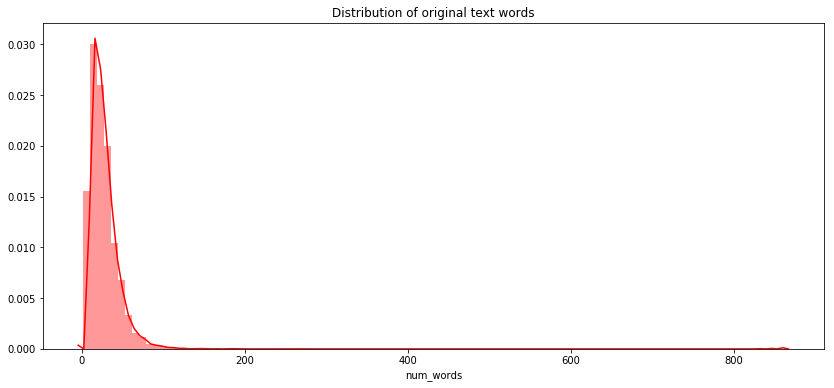

In [13]:
plt.figure(figsize=(14,6))
sns.distplot(train['num_words'],bins=100,color='r')
plt.title('Distribution of original text words')
plt.show()

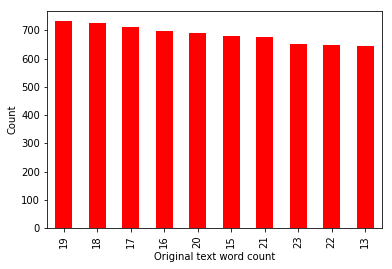

In [14]:
train['num_uniq_words'].value_counts()[0:10].plot(kind='bar',color=['r','y'])
plt.xlabel('Original text word count')
plt.ylabel('Count')
plt.show()

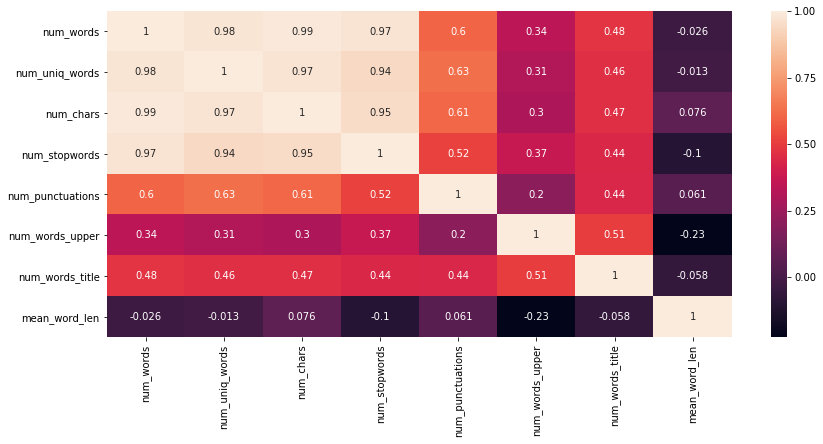

In [15]:
plt.figure(figsize=(14,6))
sns.heatmap(train.corr(),annot=True)
plt.show()

# Bag of words

In [16]:
cv =CountVectorizer(max_features=2000,ngram_range=(1,3),dtype=np.int8,stop_words='english')
X_cv = cv.fit_transform(train['clean_text']).toarray()
X_test_cv = cv.fit_transform(test['clean_text']).toarray()

# Encoder

In [17]:
author_name = {'EAP':0,'HPL':1,'MWS':2}
y = train['author'].map(author_name) 

# Naive Bayes classifier

In [18]:
mNB = MultinomialNB()

kf = KFold(n_splits=10,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score = []
i=1
for train_index,test_index in kf.split(X_cv):
    print('{} of KFlod {}'.format(i,kf.n_splits))    
    xtr,xvl = X_cv[train_index], X_cv[test_index]
    ytr,yvl = y[train_index], y[test_index]
    
    mNB.fit(xtr,ytr)
    y_mNB = mNB.predict(xvl)
    cv_score.append(log_loss(yvl,mNB.predict_proba(xvl)))    
    pred_test_full += mNB.predict_proba(X_test_cv)
    i+=1
#roc_auc_score(yvl,mNB.predict_proba(xvl)[:,1]) # not for multi class
print(cv_score)
print('Mean accuracy score',np.mean(cv_score))
print('confusion matrix:\n',confusion_matrix(yvl,y_mNB))
del xtr,ytr,xvl,yvl

1 of KFlod 10
2 of KFlod 10
3 of KFlod 10
4 of KFlod 10
5 of KFlod 10
6 of KFlod 10
7 of KFlod 10
8 of KFlod 10
9 of KFlod 10
10 of KFlod 10
[0.59689706351951599, 0.58988850127889836, 0.58955693915553997, 0.65812700400290991, 0.65499324127538805, 0.63974795442474608, 0.59900765358400587, 0.64898025072412602, 0.60501890251327195, 0.62993575596064977]
Mean accuracy score 0.621215326644
confusion matrix:
 [[607  92 109]
 [ 84 417  47]
 [ 94  47 460]]


#  Submit prediction for unseen dataset

In [19]:
y_pred = pred_test_full/10
submit = pd.DataFrame(test['id'])
submit = submit.join(pd.DataFrame(y_pred))
submit.columns = ['id','EAP','HPL','MWS'] 
#submit.to_csv('spooky_pred1.csv.gz',index=False,compression='gzip')
submit.to_csv('spooky_pred1.csv',index=False)

# TfIdf  (Term frequency Inverse document frequency)

In [20]:
tfidf = TfidfVectorizer(max_features=2000,dtype=np.float32,analyzer='word',
                        ngram_range=(1, 3),use_idf=True, smooth_idf=True, 
                        sublinear_tf=True)
X_tf = tfidf.fit_transform(train['clean_text']).toarray()
X_test_tf = tfidf.fit_transform(test['clean_text']).toarray()

# Naive Bayes classifier

In [21]:
mNB = MultinomialNB()

kf = KFold(n_splits=10,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score = []
i=1
for train_index,test_index in kf.split(X_tf):
    print('{} of KFlod {}'.format(i,kf.n_splits))    
    xtr,xvl = X_tf[train_index], X_tf[test_index]
    ytr,yvl = y[train_index], y[test_index]
    
    mNB.fit(xtr,ytr)
    y_mNB = mNB.predict(xvl)
    cv_score.append(log_loss(yvl,mNB.predict_proba(xvl)))    
    pred_test_full += mNB.predict_proba(X_test_tf)
    i+=1
#roc_auc_score(yvl,mNB.predict_proba(xvl)[:,1]) # not for multi class
print(cv_score)
print('Mean accuracy score',np.mean(cv_score))
print('confusion matrix:\n',confusion_matrix(yvl,y_mNB))
del xtr,ytr,xvl,yvl

1 of KFlod 10
2 of KFlod 10
3 of KFlod 10
4 of KFlod 10
5 of KFlod 10
6 of KFlod 10
7 of KFlod 10
8 of KFlod 10
9 of KFlod 10
10 of KFlod 10
[0.64299623781010973, 0.64558436917039486, 0.62894661723253509, 0.65331818533548425, 0.66290949833883073, 0.65025300581766043, 0.64577998503639611, 0.6504665580915252, 0.65250254836242971, 0.64619432149438283]
Mean accuracy score 0.647895132669
confusion matrix:
 [[649  68  91]
 [107 398  43]
 [121  41 439]]


#  Submit prediction for unseen dataset

In [22]:
y_pred = pred_test_full/10
submit = pd.DataFrame(test['id'])
submit = submit.join(pd.DataFrame(y_pred))
submit.columns = ['id','EAP','HPL','MWS'] 
#submit.to_csv('spooky_pred2.csv.gz',index=False,compression='gzip')
submit.to_csv('spooky_pred2.csv',index=False)

# Merge

In [23]:
#filter data set
unwanted = ['text','id','clean_text']
X_tf = np.concatenate((X_tf,train.drop(unwanted+['author'],axis=1).values),axis=1)
X_test_tf = np.concatenate((X_test_tf,test.drop(unwanted,axis=1).values),axis=1)


# Xgboost

In [24]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.1,early_stop=50,max_depth=5,n_rounds=1000):
    
    params = {        
        'objective':'multi:softprob',
        'learning_rate':eta,
        'max_depth':max_depth,
        'num_class':3,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'eval_metric':'mlogloss',
        'min_child_weight':10,
        'reg_alpha':1.5, 
        'reg_lambda':5,
        'scale_pos_weight':1,  
        #'verbose':0,
        'seed':seed,        
        'n_thread':-1 
    }
    
    #plst = list(params.items())
    dtrain =xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)    
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,n_rounds,evals=watchlist,early_stopping_rounds=early_stop,verbose_eval=10)
    pred = model.predict(dvalid,ntree_limit = model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit = model.best_ntree_limit)
    
    return pred_test,model

In [25]:
kf = KFold(n_splits=2,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score = []
i=1
for train_index,test_index in kf.split(X_tf):
    print('{} of KFlod {}'.format(i,kf.n_splits))    
    xtr,xvl = X_tf[train_index], X_tf[test_index]
    ytr,yvl = y[train_index], y[test_index]
        
    pred_xgb,xg_model = runXGB(xtr,xvl,ytr,yvl,X_test_tf,n_rounds=200,eta=0.5)
    pred_test_full += pred_xgb
    cv_score.append(xg_model.best_score)
    i+=1
#roc_auc_score(yvl,mNB.predict_proba(xvl)[:,1]) # not for multi class
#print(cv_score)
#print('Mean accuracy score',np.mean(cv_score))
#del xtr,ytr,xvl,yvl,X_tf,X_test_tf

1 of KFlod 2
[0]	train-mlogloss:1.02967	test-mlogloss:1.03532
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[10]	train-mlogloss:0.862991	test-mlogloss:0.89447
[20]	train-mlogloss:0.793331	test-mlogloss:0.838271
[30]	train-mlogloss:0.746533	test-mlogloss:0.803468
[40]	train-mlogloss:0.711269	test-mlogloss:0.778934
[50]	train-mlogloss:0.682013	test-mlogloss:0.761029
[60]	train-mlogloss:0.655787	test-mlogloss:0.7454
[70]	train-mlogloss:0.632102	test-mlogloss:0.734123
[80]	train-mlogloss:0.613099	test-mlogloss:0.723632
[90]	train-mlogloss:0.598267	test-mlogloss:0.716388
[100]	train-mlogloss:0.584368	test-mlogloss:0.70968
[110]	train-mlogloss:0.570928	test-mlogloss:0.704255
[120]	train-mlogloss:0.558746	test-mlogloss:0.700181
[130]	train-mlogloss:0.547226	test-mlogloss:0.698875
[140]	train-mlogloss:0.537171	test-mlogloss:0.695526
[150]	train-mlogloss:0.526907	test-mlogloss:0.693684
[160]

Increase Kflood to 5,10, number of rounds to 500,1000,2000

In [26]:
print(cv_score)
print('Mean accuracy score',np.mean(cv_score))

[0.689832, 0.689733]
Mean accuracy score 0.6897825


#  Submit prediction for unseen dataset

In [27]:
y_pred = pred_test_full/2
submit = pd.DataFrame(test['id'])
submit = submit.join(pd.DataFrame(y_pred))
submit.columns = ['id','EAP','HPL','MWS'] 
#submit.to_csv('spooky_pred3.csv.gz',index=False,compression='gzip')
submit.to_csv('spooky_pred3.csv',index=False)

# If like it please Upvote, Thank you for visiting 